# StyleGAN2-ADA 

### Reference
- [Paper | Training Generative Adversarial Networks with Limited Data](https://papers.nips.cc/paper/2020/file/8d30aa96e72440759f74bd2306c1fa3d-Paper.pdf)
- [Official PyTorch implementation | NVlabs | stylegan2-ada-pytorch | github](https://github.com/NVlabs/stylegan2-ada-pytorch)
- [NVlabs | pre-trained model](https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/)

![image](https://github.com/NVlabs/stylegan2-ada-pytorch/raw/main/docs/stylegan2-ada-teaser-1024x252.png)

---
All the codes are based on the [official pytorch implementation](https://github.com/NVlabs/stylegan2-ada-pytorch) and reorganized in the form of a Jupyter notebook for easy reading and practice.

So, let's start step by step by reading the table of contents

### index

```
Step 1. Initial Setting and load pre-trained model
     1-a. import libraries
     1-b. clone the stylegan2-ada's git repository
     1-c. load pre-trained model that trained on afhqdog dataset
Step 2. generate sample fake-dog images
     2-a. a quick look at the model
     2-b. try submodels : g_mapping, g_synthesis
Step 3. image morphing
     3-a. create 2 random vector z and 2 intermediate latent space w
     3-b. generate 2 target  images
     3-c. control `z` and try image interpolation
Step 4. Project sample image to the latent space of pretrained network
     4-a. load a target image
     4-b. transform image file to numpy array
     4-c. load the pre-trained Generator
     4-d. Compute w stats
     4-e. Setup noise inputs
     4-f. Load VGG16 feature detector
     4-g. Extract features for target image
     4-h. Set optimizer and Initiate noise
     4-i. projection(training)
     4-j. Compare the target image with the generated image
Step 5. Style Conversion
     5-a. Extract information about smiling expressions
     5-b. Import w to insert facial expressions
```

### Step 1. Initial Setting and load pre-trained model

In [1]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

**1-a. Import Libraries**

In [2]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from PIL import Image

import numpy as np

import copy
import pickle
import os

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

**1-b. clone the `stylegan2-ada`'s git repository**

In [3]:
# add align_images.py
!git clone https://github.com/rkuo2000/stylegan2-ada-pytorch
%cd stylegan2-ada-pytorch

fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.
/content/stylegan2-ada-pytorch


In [4]:
if not os.path.isdir("pretrained"):
  !mkdir pretrained
  %cd pretrained
  !wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
  %cd ../

**1-c. load pre-trained model that trained on `ffhq` dataset**

In [5]:
# Retrieving Generator
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

with open('pretrained/ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()
if device_name == "cpu":
  G.synthesis.forward = functools.partial(G.synthesis.forward, force_fp32=True)

%cd ..

### Step 2. generate sample fake-dog images

**2-a. A quick look at the model**

The image generator `G` can be used like this :

In [6]:
z = torch.randn([1, G.z_dim]).cuda()
c = None
img = G(z,c)

Setting up PyTorch plugin "bias_act_plugin"... 

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


In [7]:
img.size()

torch.Size([1, 3, 1024, 1024])

In [8]:
torch.min(img)

tensor(-1.1236, device='cuda:0')

In [9]:
img.squeeze(0).size()

torch.Size([3, 1024, 1024])

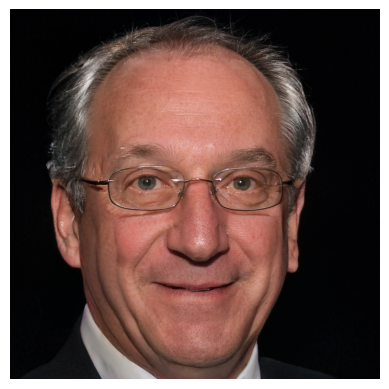

In [10]:
plt.imshow( (img[0]* 127.5 + 128).permute(1,2,0).clamp(0, 255).detach().cpu().to(torch.uint8))
plt.axis('off')
plt.show();

**2-b. Try submodels : g_mapping, g_synthesis**

It is also possible to divide the G model into submodels.
- we will use this method in more detail, since we plan to adjust the latent vector later

In [11]:
g_mapping = G.mapping
g_synthesis = G.synthesis

Let's take a look at the model structure to see how it is implemented

In [12]:
g_mapping

MappingNetwork(
  (fc0): FullyConnectedLayer()
  (fc1): FullyConnectedLayer()
  (fc2): FullyConnectedLayer()
  (fc3): FullyConnectedLayer()
  (fc4): FullyConnectedLayer()
  (fc5): FullyConnectedLayer()
  (fc6): FullyConnectedLayer()
  (fc7): FullyConnectedLayer()
)

In [13]:
g_synthesis

SynthesisNetwork(
  (b4): SynthesisBlock(
    (conv1): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (torgb): ToRGBLayer(
      (affine): FullyConnectedLayer()
    )
  )
  (b8): SynthesisBlock(
    (conv0): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (conv1): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (torgb): ToRGBLayer(
      (affine): FullyConnectedLayer()
    )
  )
  (b16): SynthesisBlock(
    (conv0): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (conv1): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (torgb): ToRGBLayer(
      (affine): FullyConnectedLayer()
    )
  )
  (b32): SynthesisBlock(
    (conv0): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (conv1): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (torgb): ToRGBLayer(
      (affine): FullyConnectedLayer()
    )
  )
  (b64): SynthesisBlock(
    (conv0): SynthesisLayer(
      (affine): FullyConnec

make latent vector(space) `z` from random gaussian distribution

In [14]:
z = torch.randn([1, G.z_dim]).cuda()
z.size()

torch.Size([1, 512])

transforms `z` into the intermediate latent space `w` (disentangled space)

In [15]:
w = g_mapping(z, None)
w.size()

torch.Size([1, 18, 512])

Now pass `w`(transformed `z`) through the synthesis network to create the `fake image`

In [16]:
img = g_synthesis(w)
img = img.cpu()

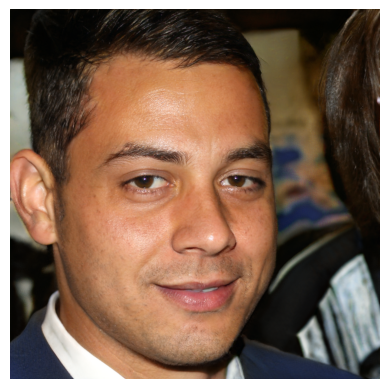

In [17]:
plt.imshow( (img[0]* 127.5 + 128).permute(1,2,0).clamp(0, 255).detach().cpu().to(torch.uint8))
plt.axis('off')
plt.show();

### Step 3. image morphing

Image Morphing | meaning
- (computing) The smooth transformation of one image into another


**3-a. create 2 random vector `z` and 2 intermediate latent space `w`**

In [18]:
z1 = torch.randn([1, G.z_dim]).cuda()
z2 = torch.randn([1, G.z_dim]).cuda()

w1 = g_mapping(z1, None)
w2 = g_mapping(z2, None)

**3-b. generate 2 target fake-dog images**

In [19]:
img1 = g_synthesis(w1)
img2 = g_synthesis(w2)

img1 = img1
img1 = img1.squeeze().permute(1,2,0)

img2 = img2
img2 = img2.squeeze().permute(1,2,0)

In [20]:
imgs = torch.cat([img1,img2], axis=1).cpu()
imgs.size()

torch.Size([1024, 2048, 3])

In [21]:
imgs = (imgs* 127.5 + 128).clamp(0, 255).to(torch.uint8)

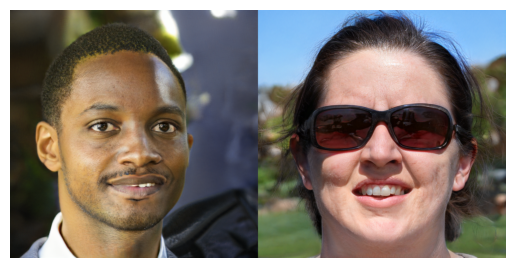

In [22]:
plt.imshow(imgs) # Increase the brightness by adding 0.85 to the pixel values
plt.axis('off')
plt.show()

**3-c. control `z` and try image interpolation**

In [23]:
img_group = []
lin = np.linspace(0, 1, 10)
print(*lin) # unpack the list

0.0 0.1111111111111111 0.2222222222222222 0.3333333333333333 0.4444444444444444 0.5555555555555556 0.6666666666666666 0.7777777777777777 0.8888888888888888 1.0


In [24]:
with torch.no_grad():
    for i in lin:
        w = ((1-i) * w1) + (i * w2) # style transfrom in for-loop : w1 --> w2
        result = g_synthesis(w)
        result = result.squeeze()
        img_group.append(result)

In [25]:
img_group = torch.cat(img_group).cpu()
img_group.size()

torch.Size([30, 1024, 1024])

This form is not an image. Let's change the shape to `NxCxHxW` and make it an image

In [26]:
img_group = img_group.view(10,3,1024,1024)
img_group.size()

torch.Size([10, 3, 1024, 1024])

And since we will represent the entire image with one image, let's represent 10(`N`) images as a grid.

In [27]:
grid_img = torchvision.utils.make_grid(img_group, nrow=5)
grid_img.size()

torch.Size([3, 2054, 5132])

In [28]:
grid_img = (grid_img* 127.5 + 128).clamp(0, 255).to(torch.uint8)

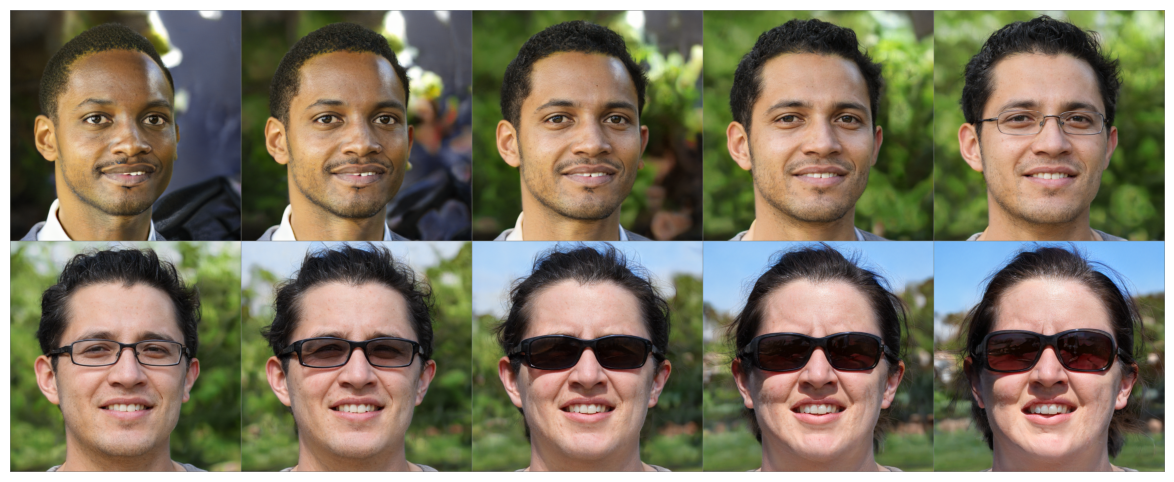

In [29]:
plt.figure(figsize=(16,6))
plt.imshow(grid_img.permute(1,2,0)) # The brightness value was also given by 0.85
plt.axis('off')
plt.show()

### Step 5. Style Conversion

In order to have more control on the styles of the generated image, the synthesis network provides control over the style to different level of details (or resolution). These different levels are defined as:
* **Coarse** – resolution of  ( 4×4 – 8×8) – affects pose, general hair style, face shape, etc
* **Middle**  – resolution of (16×16 – 32×32) – affects finer facial features, hair style, eyes open/closed, etc.
* **Fine** – resolution of (64×64 – 1024×1024) – affects colors for (eye, hair and skin) and micro features.

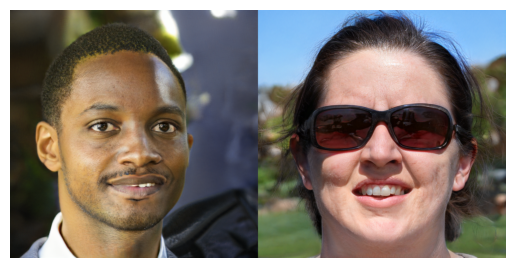

In [39]:
plt.imshow(imgs) # Increase the brightness by adding 0.85 to the pixel values
plt.axis('off')
plt.show()

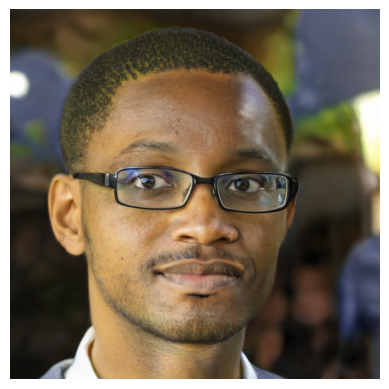

In [43]:
w_coarse=torch.cat((w2[:,:2], w1[:,2:]), dim=1)
img = g_synthesis(w_coarse)
img = img.cpu()

plt.imshow( (img[0]* 127.5 + 128).permute(1,2,0).clamp(0, 255).detach().cpu().to(torch.uint8))
plt.axis('off')
plt.show();

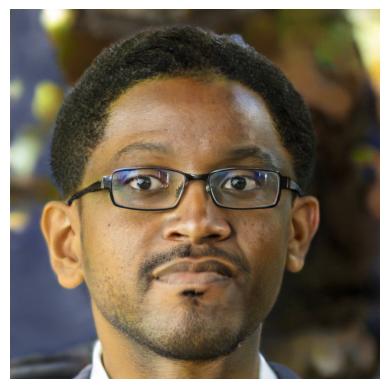

In [44]:
w_middle=torch.cat((w1[:,:2],w2[:,2:4], w1[:,4:]), dim=1)
img = g_synthesis(w_middle)
img = img.cpu()

plt.imshow( (img[0]* 127.5 + 128).permute(1,2,0).clamp(0, 255).detach().cpu().to(torch.uint8))
plt.axis('off')
plt.show();

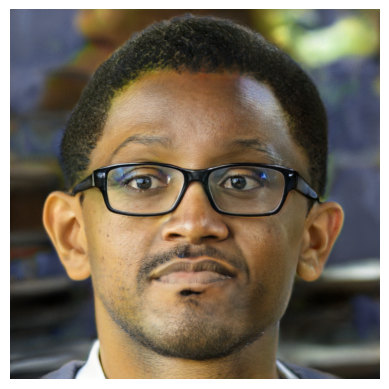

In [46]:
w_fine =torch.cat((w2[:,:4], w1[:,4:]), dim=1)
img = g_synthesis(w_fine)
img = img.cpu()

plt.imshow( (img[0]* 127.5 + 128).permute(1,2,0).clamp(0, 255).detach().cpu().to(torch.uint8))
plt.axis('off')
plt.show();